In [3]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
np.random.seed(107)
import matplotlib.pyplot as plt

<AxesSubplot:>

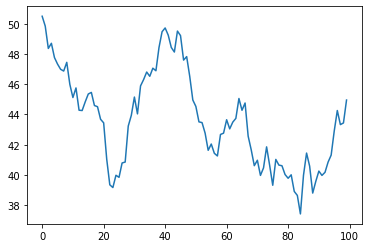

In [4]:
X_returns=np.random.normal(0,1,100)
X = pd.Series(np.cumsum(X_returns),name='X')+50
X.plot()

<AxesSubplot:>

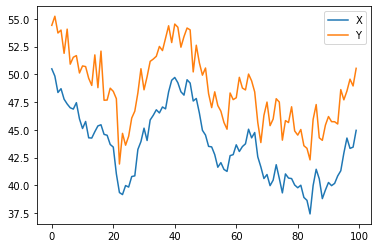

In [5]:
some_noise=np.random.normal(0,1,100)
Y = X+5+some_noise
Y.name = 'Y'
pd.concat([X,Y],axis=1).plot()

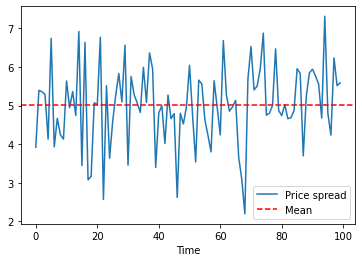

In [6]:
(Y - X).plot() # plot the spread
plt.axhline((Y-X).mean(),color='red',linestyle = '--')
plt.xlabel('Time')
plt.legend(['Price spread','Mean'])

In [9]:
score,pvalue,_ = coint(X,Y)
print(pvalue)

2.0503418653415035e-16


In [11]:
score,pvalue,_ = coint(X,some_noise)
print(pvalue)

0.3375321169189971


In [10]:
X.corr(Y)

0.9497090646385932

In [15]:
import pandas_datareader as pdr
key='bfefa72b58ce16638e4384eb6beea09403def336'
df_g = pdr.get_data_tiingo('GOOG', api_key=key)
df_g.to_csv('goog.csv')
df_g=pd.read_csv('goog.csv')
df_g.tail()

/home/ohj/.local/lib/python3.10/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,GOOG,2023-03-20 00:00:00+00:00,101.93,102.5800,100.79,101.06,26033916,101.93,102.5800,100.79,101.06,26033916,0.0,1.0
1253,GOOG,2023-03-21 00:00:00+00:00,105.84,105.9600,101.86,101.98,33122800,105.84,105.9600,101.86,101.98,33122800,0.0,1.0
1254,GOOG,2023-03-22 00:00:00+00:00,104.22,107.5100,104.21,105.14,32336877,104.22,107.5100,104.21,105.14,32336877,0.0,1.0
1255,GOOG,2023-03-23 00:00:00+00:00,106.26,107.1009,105.41,105.89,31385817,106.26,107.1009,105.41,105.89,31385817,0.0,1.0
1256,GOOG,2023-03-24 00:00:00+00:00,106.06,106.1600,104.74,105.74,25245010,106.06,106.1600,104.74,105.74,25245010,0.0,1.0


In [16]:
df_a = pdr.get_data_tiingo('AAPL', api_key=key)
df_a.to_csv('AAPL.csv')
df_a=pd.read_csv('AAPL.csv')

/home/ohj/.local/lib/python3.10/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [43]:
temp=df_a[['open']]
temp=temp.rename(columns={'open':'AAPL'})
temp.keys()

Index(['AAPL'], dtype='object')

In [66]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n,n))
    pvalue_matrix = np.ones((n,n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1,n):
            S1=data[keys[i]]
            S2=data[keys[j]]
            result=coint(S1,S2)
            score=result[0]
            pvalue=result[1]
            score_matrix[i,j] = score
            pvalue_matrix[i,j] = pvalue
            if pvalue<0.05:
                pairs.append([keys[i],keys[j]])
    return score_matrix,pvalue_matrix,pairs
def generate_df(symbols):
    final_df=df_a[['open']].rename(columns={'open':'AAPL'})
    for sym in symbols:
        df = pdr.get_data_tiingo(sym, api_key=key)
        df.to_csv('{}.csv'.format(sym))
        df=pd.read_csv('{}.csv'.format(sym))
        df_price=df[['open']]
        df_price=df_price.rename(columns={'open':sym})
        final_df=pd.concat([final_df,df_price],axis=1)
    return final_df
symbol_list=['GOOGL','MSFT','AMZN','NVDA','LRCX']
top_stocks = generate_df(symbol_list)
score_matrix,pvalue_matrix,pairs=find_cointegrated_pairs(top_stocks)

/home/ohj/.local/lib/python3.10/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [68]:
symbol_list2=['AAPL']+symbol_list
p_df = pd.DataFrame(pvalue_matrix,index = symbol_list2,
                    columns = symbol_list2)
score_df = pd.DataFrame(score_matrix,index = symbol_list2,
                    columns = symbol_list2)
p_df

,AAPL,GOOGL,MSFT,AMZN,NVDA,LRCX
AAPL,1.0,0.117188,0.057566,0.123795,0.115268,0.044659
GOOGL,1.0,1.000000,0.950620,0.090270,0.828453,0.929132
MSFT,1.0,1.000000,1.000000,0.958630,0.851404,0.100255
AMZN,1.0,1.000000,1.000000,1.000000,0.691430,0.963009
NVDA,1.0,1.000000,1.000000,1.000000,1.000000,0.342136
LRCX,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:
score_df

,AAPL,GOOGL,MSFT,AMZN,NVDA,LRCX
AAPL,0.0,-2.971293,-3.279796,-2.945268,-2.979055,-3.379674
GOOGL,0.0,0.000000,-0.661655,-3.090289,-1.304240,-0.840762
MSFT,0.0,0.000000,0.000000,-0.573961,-1.224370,-3.043359
AMZN,0.0,0.000000,0.000000,0.000000,-1.667832,-0.518217
NVDA,0.0,0.000000,0.000000,0.000000,0.000000,-2.363903
LRCX,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [70]:
pairs

[['AAPL', 'LRCX']]

In [128]:
top_stocks.head(3)

,AAPL,GOOGL,MSFT,AMZN,NVDA,LRCX
0,167.25,1001.91,89.82,1447.00,224.13,199.63
1,167.81,1011.21,90.18,1406.00,224.11,198.10
2,166.64,1027.62,90.47,1417.62,228.74,201.49


[['AAPL', 'LRCX']]


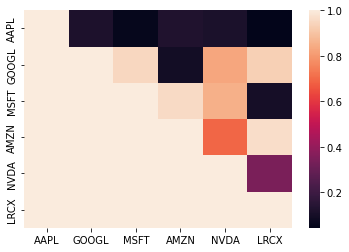

In [78]:
import seaborn as sns
sns.heatmap(pvalue_matrix,xticklabels=symbol_list2,
            yticklabels=symbol_list2)
print(pairs)

In [125]:
S1=top_stocks['AAPL']
S2=top_stocks['LRCX']
score,pvalue,_ = coint(S1,S2)
pvalue

0.04465876484333117

In [126]:
S1=np.array(S1).reshape(-1,1)
S2=np.array(S2).reshape(-1,1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(S1)
scaler.fit(S2)
S1=scaler.transform(S1)
S2=scaler.transform(S2)

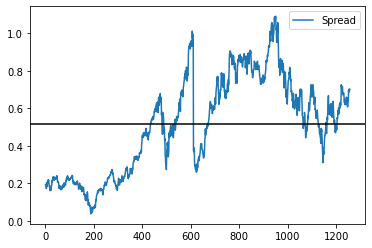

In [127]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2,S1).fit()
S1=S1[:,1].reshape(-1,1)
b = results.params[1]

spread = pd.DataFrame(S2-b*S1)

spread.plot()
plt.axhline(spread[0].mean(),color = 'black')
plt.legend(['Spread'])

/tmp/ipykernel_40751/1688543301.py:1: RuntimeWarning: divide by zero encountered in true_divide
  ratio = S1/S2


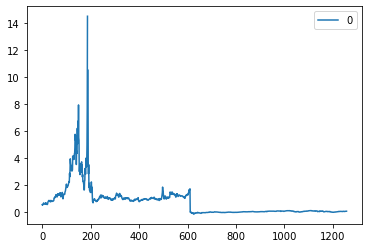

In [134]:
ratio = S1/S2
ratio=pd.DataFrame(ratio)
ratio.plot()
plt.axhline(ratio[0].mean(),color='black')

In [142]:
zscore(spread)[0].mean()

-4.522149471822436e-17

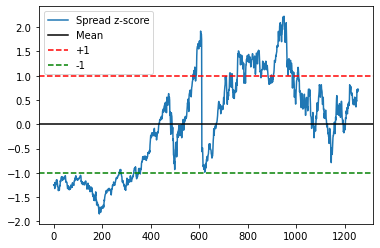

In [147]:
def zscore(series):
    return (series-series.mean())/np.std(series)
zscore(spread).plot()
plt.axhline(zscore(spread)[0].mean(),color = 'black')
plt.axhline(1.0,color = 'red',linestyle = '--')
plt.axhline(-1.0,color = 'green',linestyle = '--')
plt.legend(['Spread z-score','Mean','+1','-1'])

Text(0, 0.5, 'Spread')

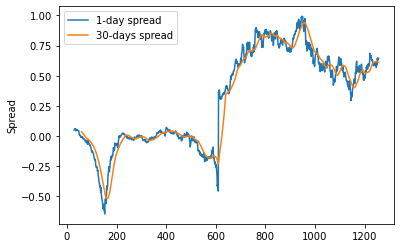

In [184]:
from statsmodels.regression.rolling import RollingOLS
model = RollingOLS(endog =S1, exog=S2,window=30)
rres = model.fit()
spread=S2-rres.params*S1
spread=pd.DataFrame(spread)
spread.name='spread'
#1-day MA
spread_ma1=spread.rolling(1).mean()
spread_ma1.name='spread 1d MA'
#30-days MA
spread_ma30=spread.rolling(30).mean()
spread_ma30.name='spread 30d MA'
plt.plot(spread_ma1.index,spread_ma1.values)
plt.plot(spread_ma30.index,spread_ma30.values)
plt.legend(['1-day spread','30-days spread'])
plt.ylabel('Spread')

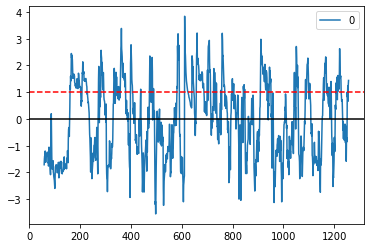

In [185]:
std_30=spread.rolling(30).std()
std_30.name='std_30'
zscore_30_1=(spread_ma1-spread_ma30)/std_30
zscore_30_1.name='z-score'
zscore_30_1.plot()
plt.axhline(0,color='black')
plt.axhline(1.0,color='red',linestyle='--')

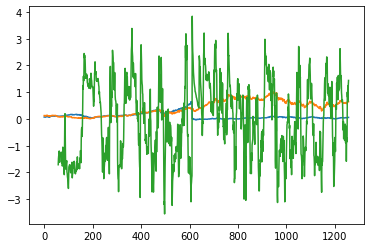

In [188]:
plt.plot(S1)
plt.plot(S2)
plt.plot(zscore_30_1)
